Step 1. 데이터 다운로드

In [1]:
# mkdir -p ~/aiffel/lyricist/models
# ln -s ~/data ~/aiffel/lyricist/data

클라우드 환경에서는 데이터가 존재하므로 Cloud shell에서 위 명령어를 입력하여 연결한다.

Step 2. 데이터 읽어오기

In [2]:
import glob
import os
import re 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 좋다.
glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 한다!

Step 3. 데이터 정제

텍스트 분류 모델에서 많이 본 것 처럼 텍스트 생성 모델에도 단어 사전을 만들게 된다.
그렇다면 문장을 일정한 기준으로 쪼개야하는데, 그 과정을 토큰화(Tokenize)라고 한다.
가장 간단한 방법은 띄어쓰기를 기준으로 나누는 것이다.
하지만 문장부호, 대소문자, 특수문자에서 문제가 발생하기 때문에 아래와 같이 해결한다.

1. Hi, my name is John. *("Hi," "my", ..., "john." 으로 분리됨) - 문장부호

2. First, open the first chapter. *(First와 first를 다른 단어로 인식) - 대소문자

3. He is a ten-year-old boy. *(ten-year-old를 한 단어로 인식) - 특수문자

"1." 을 막기 위해 문장 부호 양쪽에 공백을 추가한다.

"2." 를 막기 위해 모든 문자들을 소문자로 변환한다. 

"3." 을 막기 위해 특수문자들은 모두 제거한다.

이런 전처리를 위해 정규표현식(Regex)을 이용한 필터링이 유용하게 사용된다.

In [3]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>



위와 같이 지저분한 문장을 넣어도 깔끔한 문장으로 변환하는 정제 함수가 완성된 것을 볼 수 있다. start와 end도 추가된 것을 볼 수 있다.

In [4]:
# 언어 모델의 입력 문장 :  <start> 나는 밥을 먹었다
# 언어 모델의 출력 문장 : 나는 밥을 먹었다 <end>
# 자연어처리 분야에서 모델의 입력이 되는 문장을 소스 문장(Source Sentence)이라 한다.
# 정답 역할을 하게 될 모델의 출력 문장을 타겟 문장(Target Sentence)이라고 관례적으로 부른다.
# 각각 X_train, y_train 에 해당한다.
# 정제 함수를 통해 만든 데이터셋에서 토큰화를 진행한 후 끝 단어 <end>를 없애면 소스 문장, 첫 단어 <start>를 없애면 타겟 문장이 된다.

In [5]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    tmp = preprocess_sentence(sentence)    
    if len(tmp.split()) > 15: continue    
    corpus.append(tmp)
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the fourth , the fifth <end>']

In [6]:
# 새로운 언어를 배우려면 사전이 필요한데, 에를 들면 영어를 공부할 때 한영사전이 필요하다.
# 인공지능도 배우고자 하는 언어가 있다면 모국어로 표현을 해야 공부할 수 있다.
# 인공지능의 모국어라면 숫자이기 때문에 가르칠 언어(데이터)를 숫자로 변환해서 인공지능에게 주어야 한다.

In [7]:
# 텐서플로우는 자연어 처리를 위한 여러 가지 모듈을 제공한다.
# tf.keras.preprocessing.text.Tokenizer 패키지는 정제된 데이터를 토큰화하고, 단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어준다.
# tf.keras.preprocessing.text.Tokenizer 패키지는 데이터를 숫자로 변환까지 해준다.
# 이 과정을 벡터화(vectorize)라 하며 숫자로 변환된 데이터를 텐서(tensor) 라고 칭한다.
# 우리가 사용하는 텐서플로우로 만든 모델의 입출력 데이터는 실제로는 모두 이런 텐서로 변환되어 처리되는 것이다.

In [8]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 12000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   50    4 ...    0    0    0]
 [   2   15 2967 ...    0    0    0]
 ...
 [   2  258  194 ...    0    0    0]
 [   2    7   34 ...    0    0    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f4ef439ffd0>


In [9]:
print(tensor[:3, :10])

[[   2   50    4   95  303   62   53    9  946 6263]
 [   2   50    4   95  303   62   53    9  946 6263]
 [   2   15 2967  871    5    8   11 5739    6  374]]


생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력해 보니 모두 정수로 이루어져 있는 것을 확인할 수 있다. 이 숫자는 tokenizer에 구축된 단어 사전의 인덱스이다.

In [10]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


2번 인덱스가 바로 start였다. 이제 모든 행이 왜 2로 시작하는지 이해할 수 있다.

In [11]:
# 이제 생성된 텐서를 소스와 타겟으로 분리하여 모델이 학습할 수 있게 하겠다. 이 과정도 텐서플로우 가 제공하는 모듈을 사용할 것이다.

In [12]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2   50    4   95  303   62   53    9  946 6263    3    0    0    0
    0    0    0    0    0]
[  50    4   95  303   62   53    9  946 6263    3    0    0    0    0
    0    0    0    0    0]


텐서 출력부에서 행 뒤쪽에 0이 많이 나온 부분은 정해진 입력 시퀀스 길이보다 문장이 짧을 경우 0으로 패딩(padding)을 채워 넣은 것이다. 사전에는 없지만 0은 바로 패딩 문자 pad가 될 것이다.

corpus 내의 첫 번째 문장에 대해 생성된 소스와 타겟 문장을 확인해 보았다. 예상대로 소스는 2(<start>)에서 시작해서 3(<end>)으로 끝난 후 0(<pad>)로 채워져 있다. 하지만 타겟은 2로 시작하지 않고 소스를 왼쪽으로 한 칸 시프트 한 형태를 가지고 있다.

마지막으로 우리는 데이터셋 객체를 생성할 것이다. 그동안 우리는 model.fit(x_train, y_train, ...) 형태로 Numpy Array 데이터셋을 생성하여 model에 제공하는 형태의 학습을 많이 진행해 왔다. 그러나 텐서플로우를 활용할 경우 텐서로 생성된 데이터를 이용해 tf.data.Dataset객체를 생성하는 방법을 흔히 사용한다. tf.data.Dataset객체는 텐서플로우에서 사용할 경우 데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능을 제공한다. 우리는 이미 데이터셋을 텐서 형태로 생성해 두었으므로, tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성할 것이다.

In [13]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

dataset을 얻었다.

이번 스텝에서 데이터셋을 생성하기 위해 거쳐 온 과정을 기억해두자

● 정규표현식을 이용한 corpus 생성
● tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환
● tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환

이 모든 일련의 과정을 텐서플로우에서의 데이터 전처리라 칭한다.

Step 4. 평가 데이터셋 분리

In [14]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)    # 34유지
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (249620, 19)
Target Train:  (249620, 19)


In [15]:
from tensorflow.keras.layers import Embedding, LSTM, Dense

텐서플로우를 활용할 경우 텐서로 생성된 데이터를 이용해 tf.data.Dataset객체를 생성하는 방법을 흔히 사용한다. tf.data.Dataset객체는 텐서플로우에서 사용할 경우 데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능을 제공한다. 우리는 이미 데이터셋을 텐서 형태로 생성해 두었으므로, tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성할 것이다.

In [16]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256                     # 300~500선을 많이 선택하는데 데이터가 크지 않으면 작게 설정해도 되므로 256유지
hidden_size = 1024                       # hidden_size는 데이터가 크지 않다고 판단하여 최초 1024 유지
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

우리 입력 텐서에는 단어 사전의 인덱스가 들어 있다. Embedding 레이어는 이 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔 준다. 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용된다.

위 코드에서 embedding_size 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기이다. 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만, 그만큼 충분한 데이터가 주어지지 않으면 오히려 혼란만을 야기할 수 있다.

LSTM 레이어의 hidden state 의 차원수인 hidden_size 도 같은 맥락이다. hidden_size 는 모델에 얼마나 많은 일꾼을 둘 것인가로 이해해도 크게 엇나가지 않는다. 그 일꾼들은 모두 같은 데이터를 보고 각자의 생각을 가지는데, 역시 충분한 데이터가 주어지면 올바른 결정을 내리겠지만 그렇지 않으면 배가 산으로 갈 뿐이다.

우리의 model은 아직 제대로 build되지 않았다. model.compile()을 호출한 적도 없고, 아직 model의 입력 텐서가 무엇인지 제대로 지정해 주지도 않았기 때문이다.
그런 경우 아래와 같이 model에 데이터를 아주 조금 태워 보는 것도 방법이다. model의 input shape가 결정되면서 model.build()가 자동으로 호출된다.

In [17]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 19, 12001), dtype=float32, numpy=
array([[[-1.11629515e-05,  1.26989937e-04,  9.02246829e-05, ...,
          1.91337404e-05,  7.45989382e-05, -6.00094154e-06],
        [-5.35248910e-05,  1.85558878e-04,  2.20459100e-04, ...,
         -1.43060761e-05,  1.37291674e-04, -4.00030869e-04],
        [-1.71528314e-04,  3.72003647e-04,  1.83880584e-05, ...,
         -4.57298120e-05,  5.40205183e-05, -7.10886146e-04],
        ...,
        [-2.35726126e-03,  1.69966416e-03, -5.31193509e-04, ...,
         -2.91661127e-04, -1.97395639e-04, -2.04080658e-04],
        [-2.95212562e-03,  1.58388074e-03, -3.99956334e-04, ...,
         -2.14574218e-04, -5.92319586e-04,  9.09498485e-05],
        [-3.48410034e-03,  1.48092082e-03, -2.34331528e-04, ...,
         -1.10285495e-04, -9.87851992e-04,  3.66209453e-04]],

       [[-1.11629515e-05,  1.26989937e-04,  9.02246829e-05, ...,
          1.91337404e-05,  7.45989382e-05, -6.00094154e-06],
        [-7.69956532e-05,  1.88241655e-04,  1

모델의 최종 출력 텐서 shape를 유심히 보면 shape=(256, 19, 12001)임을 알 수 있다. 12001은 Dense 레이어의 출력 차원수이다. 12001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링해야 하기 때문이다.
256은 이전 스텝에서 지정한 배치 사이즈이다. dataset.take(1)를 통해서 1개의 배치, 즉 256개의 문장 데이터를 가져온 것이다.

그렇다면 19는 무엇을 의미할까? 비밀은 바로 tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한 LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있다. 즉, LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미이다. 만약 return_sequences=False였다면 LSTM 레이어는 1개의 벡터만 출력했을 것이다.

그런데 문제는, 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점이다. 모델을 만들면서 알려준 적도 없다. 그럼 19는 언제 알게된 것일까? 바로 데이터를 입력받으면서 비로소 알게 된 것이다. 우리 데이터셋의 max_len이 20으로 맞춰져 있었던 것이다.

In [18]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  3072256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


이제 드디어 model.summary()를 호출할 수 있게 되었다. 그런데 호출해 보니 그동안 많이 보았던 것과는 다른 점이 있다. 우리가 궁금했던 Output Shape를 정확하게 알려주지 않았다. 바로 위에서 설명한 이유 때문이다. 우리의 모델은 입력 시퀀스의 길이를 모르기 때문에 Output Shape를 특정할 수 없는 것이다.

하지만 모델의 파라미터 사이즈는 측정된다. 대략 29million 정도 된다.

In [19]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()                                 #(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
history = model.fit(enc_train, 
          dec_train, 
          epochs=5,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/5
976/976 [==============================] - 254s 258ms/step - loss: 2.4917 - accuracy: 0.6269 - val_loss: 2.2179 - val_accuracy: 0.6471
Epoch 2/5
976/976 [==============================] - 257s 263ms/step - loss: 2.1018 - accuracy: 0.6555 - val_loss: 2.0342 - val_accuracy: 0.6595
Epoch 3/5
976/976 [==============================] - 257s 264ms/step - loss: 1.9279 - accuracy: 0.6680 - val_loss: 1.8971 - val_accuracy: 0.6710
Epoch 4/5
976/976 [==============================] - 257s 264ms/step - loss: 1.7809 - accuracy: 0.6809 - val_loss: 1.7833 - val_accuracy: 0.6832
Epoch 5/5
976/976 [==============================] - 257s 263ms/step - loss: 1.6470 - accuracy: 0.6957 - val_loss: 1.6833 - val_accuracy: 0.6957


In [20]:
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

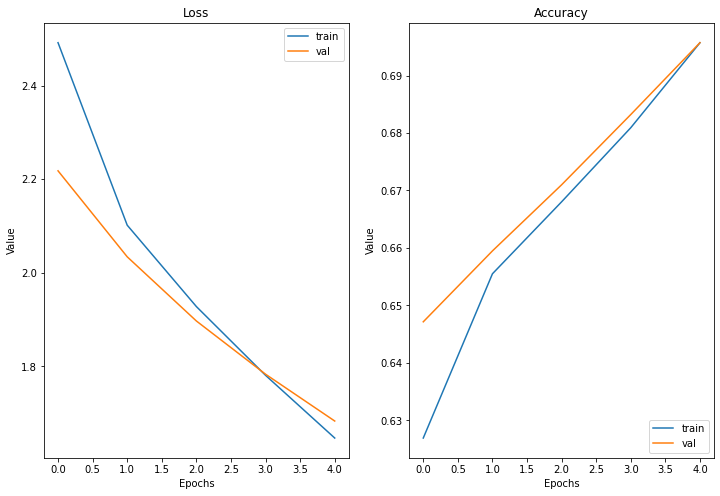

In [21]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [22]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [26]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i m a liability <end> '

"i love"로 시작하는 문장을 만들어 낸 것을 확인할 수 있다.

EXPLORATION 4 회고

EXPLORATION 4는 인공지능이 문장을 이해하여 작문을 할 수 있게 하는 프로젝트였다. 과정은 어렵지만 재미가 있었다. 내가 시작 하라고 한 문장으로 뒷 문장을 만들어내는 것을 보면서 살짝 뿌듯했다. 이번 프로젝트에서 가장 어려웠던 것은 RNN과 LSTM을 이해하는 것이었다. RNN은 하나의 네트워크가 여러 개 복사된 형태로 구성되어 있고, 각 네트워크는 다음 단계로 정보를 넘겨준다. 순서를 고려한 처리가 가능하기 때문에 모든 sequence data를 가뿐히 처리할 수 있을 것 같지만 문제가 생긴다. 이 문제를 해결한 것이 LSTM이다. RNN은 싱글레이어였지만 LSTM 네트워크는 훨씬 복잡한 구조를 가지고 있다. LSTM에는 상호작용을 하는 4개의 레이어가 존재하고, 이 구조가 반복되는 모듈을 가지는 것이 LSTM이다. 그림을 보면서 두 개념을 이해를 하였으나, 더 깊게 파고들어 이해할 필요가 있다. 또 어려웠을 수도 있는데 생각을 단순하게 하여 잘 풀어낸 점은 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄이는 것이었다. Embedding Size와 Hidden Size를 조절하는 것이 힌트라고 하였는데, 데이터의 양이 많지 않다고 판단하여 적은 양이었던 shakespeare 데이터와 동일하게 하였다. 이런식의 시도를 하니 Epoch 2/5부터 2.2 수준이 맞춰졌다. 프로젝트 마지막 즈음에는 그래프를 이용한 시각화로 loss값을 그래프로 확인할 수 있다는 것을 알아냈다. 시각화가 되니 확실히 분석하기가 편했다. 마지막으로 이번 프로젝트는 알아가는 것도 많았지만, 알아내야 하는 것도 많다는 것을 느꼈다. 학습한 내용과 학습할 내용이 나중에도 큰 도움이 되길 바라며 마친다.